In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import math
from collections import defaultdict
from gym.envs.registration import register
# 問題を簡単化するためSimpleFrozenLake-v0を定義
register(id="SimpleFrozenLake-v0", entry_point="gym.envs.toy_text:FrozenLakeEnv",
         kwargs={"is_slippery": False})

In [0]:
class Agent():

    def __init__(self, epsilon):
        self.Q = {}  # 行動価値
        self.__epsilon = epsilon
        self.__rewards = []

    def initialize(self):
        self.__rewards = []

    def rewards(self, reward):
        self.__rewards.append(reward)

    def policy(self, s, actions):
        '''\epsilon-greedy法
        '''
        if np.random.random() < self.__epsilon:
            # ランダムな行動（探索）
            return np.random.randint(len(actions))
        else:
            # self.Q => 状態における行動の価値
            # self.Q[s] => 状態sで行動aをとる場合の価値
            if s in self.Q and sum(self.Q[s]) != 0:
                # 価値評価に基づき行動（活用）
                return np.argmax(self.Q[s])
            else:
                # ランダムな行動（探索）
                return np.random.randint(len(actions))
            
    def get_rewards(self):
        return self.__rewards
    
    def show_reward(self, interval=50):
        r = self.get_rewards()
        indices = list(range(0, len(r), interval))
        means = []
        stds = []
        for i in indices:
            rewards = r[i:(i + interval)]
            means.append(np.mean(rewards))
            stds.append(np.std(rewards))
        means = np.array(means)
        stds = np.array(stds)
        plt.grid()
        plt.fill_between(indices, means - stds, means + stds,
                         alpha=0.1, color="#c8c8c8")
        plt.plot(indices, means, "o-", color="black",
                 label="Rewards for each {} episode".format(interval))
        plt.plot(indices, means - stds, "--", color="#e8e8e8")
        plt.plot(indices, means + stds, "--", color="#e8e8e8")
        plt.legend(loc="best")

In [0]:
class MCAgent(Agent): # モンテカルロ法

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def trial(
        self, 
        num_episodes=500,
        gamma=0.9,
        render=False):

        with gym.make('SimpleFrozenLake-v0') as env:
            self.initialize()
            actions = list(range(env.action_space.n))
            self.Q = defaultdict(lambda: [0] * len(actions))
            N = defaultdict(lambda: [0] * len(actions))

            for e in range(num_episodes):
                observation = env.reset()

                experience = []
                while True:  # エピソードの終了まで実行
                    if render: 
                        env.render()

                    action = self.policy(observation, actions)

                    # 遷移先の状態, 報酬, 遷移先が 終了状態かどうか, 補足説明を取得
                    n_state, reward, done, _ = env.step(action)

                    experience.append({"state": observation, "action": action, "reward": reward})
                    observation = n_state

                    if done:
                        self.rewards(reward)
                        break

                # 行動修正
                for i, x in enumerate(experience):
                    s, a = x["state"], x["action"]

                    G, k = 0, 0
                    for t in range(i, len(experience)):
                        #  G_t =  r_{t+1} + \gamma r_{t+2} + \gamma^{2} r_{t+3} + ・・・ + \gamma^{T-t-1} r_{T}
                        #         = \sum_{k=0}^{T-t-1} \gamma^{k} r_{t+k+1}
                        G += math.pow(gamma, k) * experience[t]["reward"]
                        k += 1

                    # 確率的な計算方法
                    N[s][a] += 1  # 状態sで行動aと取った数
                    alpha = 1 / N[s][a]
                    
                    # 
                    # V(s_t) = V(s_t) + alpha(G - V(S_t))
                    self.Q[s][a] += alpha * (G - self.Q[s][a])  

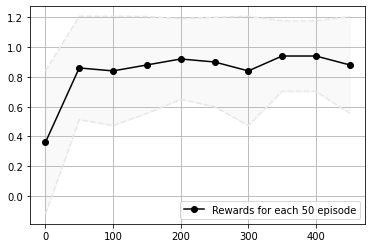

In [4]:
agent = MCAgent(epsilon=0.1)
agent.trial()
agent.show_reward()

In [0]:
def show_q(Q):
    '''
    reward_map
        0: left
        1: down
        2: right
        3: up
    '''
    env = gym.make("FrozenLake-v0")
    nrow = env.unwrapped.nrow
    ncol = env.unwrapped.ncol
    reward_map = np.zeros((nrow, ncol))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(-0.5, ncol - 0.5)
    ax.set_ylim(-0.5, nrow - 0.5)

    for r in range(nrow):
        for c in range(ncol):
            s = r * nrow + c
            _r = (nrow - 1 - r)
            if s in Q:
                reward_map[_r][c] = np.argmax(Q[s])
                #print(_r, c, Q[s])
                plt.text(c,nrow-_r-1, str(reward_map[_r][c]))
            else:
                plt.text(c,nrow-_r-1, str(0.0))
    
    ax.set_xticks(np.arange(-0.5, ncol))
    ax.set_yticks(np.arange(-0.5, nrow))
    ax.set_xticklabels(range(ncol + 1))
    ax.set_yticklabels(range(nrow + 1))
    ax.grid(which="both")

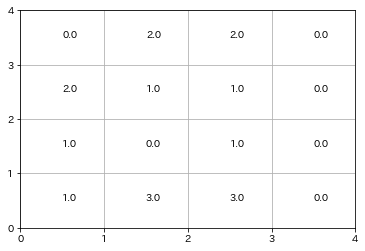

In [0]:
show_q(agent.Q)

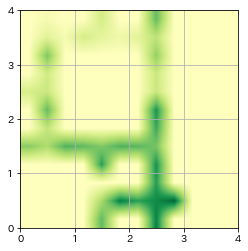

In [0]:
show_q_value(agent.Q)

In [0]:
def show_q_value(Q):
    """
    Show Q-values for FrozenLake-v0.
    To show each action's evaluation,
    a state is shown as 3 x 3 matrix like following.

    +---+---+---+
    |   | u |   |  u: up value
    | l | m | r |  l: left value, r: right value, m: mean value
    |   | d |   |  d: down value
    +---+---+---+
    """
    import matplotlib.cm as cm

    env = gym.make("FrozenLake-v0")
    nrow = env.unwrapped.nrow
    ncol = env.unwrapped.ncol
    state_size = 3
    q_nrow = nrow * state_size
    q_ncol = ncol * state_size
    reward_map = np.zeros((q_nrow, q_ncol))

    for r in range(nrow):
        for c in range(ncol):
            s = r * nrow + c
            state_exist = False
            if isinstance(Q, dict) and s in Q:
                state_exist = True
            elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
                state_exist = True

            if state_exist:
                # At the display map, the vertical index is reversed.
                _r = 1 + (nrow - 1 - r) * state_size
                _c = 1 + c * state_size
                reward_map[_r][_c - 1] = Q[s][0]  # LEFT = 0
                reward_map[_r - 1][_c] = Q[s][1]  # DOWN = 1
                reward_map[_r][_c + 1] = Q[s][2]  # RIGHT = 2
                reward_map[_r + 1][_c] = Q[s][3]  # UP = 3
                reward_map[_r][_c] = np.mean(Q[s])  # Center

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(reward_map, cmap=cm.RdYlGn, interpolation="bilinear",
               vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
    ax.set_xlim(-0.5, q_ncol - 0.5)
    ax.set_ylim(-0.5, q_nrow - 0.5)
    ax.set_xticks(np.arange(-0.5, q_ncol, state_size))
    ax.set_yticks(np.arange(-0.5, q_nrow, state_size))
    ax.set_xticklabels(range(ncol + 1))
    ax.set_yticklabels(range(nrow + 1))
    ax.grid(which="both")
